# DMU Homework 3
### Calvin Henggeler
-----

In [48]:
using DMUStudent.HW3: HW3, DenseGridWorld, visualize_tree
# using POMDPs: actions, @gen, isterminal, discount, statetype, actiontype, simulate, states, initialstate, stateindex
using POMDPs
using D3Trees: inchrome, inbrowser
using StaticArrays: SA
using Statistics: mean, std
# using BenchmarkTools: @btime
using BenchmarkTools
using QuickPOMDPs: QuickPOMDP
using POMDPTools

___
## 2 Exercises
HW3.DenseGridWorld() generates a 60x60 grid world MDP. There is a reward of +100 every 20 cells, i.e. at
[20,20], [20,40], [40,20], etc. Once the agent reaches one of these reward cells, or an edge cell, the problem
terminates. All cells also have a cost. Only a generative transition model is available. You will use the
following functions from POMDPs.jl to interact with this problem (or larger versions) in the rest of this
assignment:
• actions(m)
• @gen(:sp, :r)(m, s, a)
• isterminal(m, s)
• discount(m)
• statetype(m)
• actiontype(m)


### Problem 2

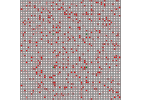

actions(m) = (:up, :down, :left, :right)


In [49]:
m = HW3.DenseGridWorld(seed=3)
@show actions(m)
display(render(m))

In [50]:
function rollout(mdp, policy_function, s0; max_steps=100)
    r_total = 0.0                                   # Initialize û
    s = s0                                          # Initial state
    t = 0
    while !isterminal(mdp, s) && t < max_steps      # While not terminal and not max steps
        a = policy_function(mdp, s)                 # Sample action from policy
        s, r = @gen(:sp,:r)(mdp, s, a)              # Generate new state and reward
        r_total += discount(mdp)^t*r                # add discounted reward to total utility
        t += 1  
    end
    return r_total
end

rollout (generic function with 2 methods)

In [51]:

function random_policy(m, s)
    return rand(actions(m))
end


# function onestep_lookahead(m, s)
#     # take action with highest immediate reward
#     A = actions(m)
#     R = reward_vectors(m)
#     a = argmax([R[:right][stateindex(m, @gen(:sp,:r)(m, s, a)[1])] for a in actions(m)])
#     return actions(m)[a]
# end

function heuristic_policy(m, s)

    # take action with highest immediate reward
    A = actions(m)
    R = reward_vectors(m)
    a = argmax([R[:right][stateindex(m, @gen(:sp,:r)(m, s, a)[1])] for a in actions(m)])
    return actions(m)[a]

end

heuristic_policy (generic function with 1 method)

In [52]:

# This code runs monte carlo simulations: you can calculate the mean and standard error from the results
@show results = [rollout(m, random_policy, rand(initialstate(m))) for _ in 1:300]
@show mean(results)
@show std(results) / sqrt(length(results))

results = [rollout(m, random_policy, rand(initialstate(m))) for _ = 1:300] = [-9.864025197408607, -235.40946063673016, -103.88643859634784, -223.29300079466705, -37.319550087715264, -0.2972555561508574, -52.46802721946222, -0.959206782907191, -6.605127609164943, -79.55088451133103, -132.15276625131662, -50.72642499079543, -174.90910106241088, -103.56105693985755, -51.833160781971216, -123.94112940059274, -80.56069203982287, -40.01945928627765, -125.21952705535038, -10.462861246821939, -103.22350009625, -56.70244541532342, -31.285058864886647, -6.191474141102713, -119.77019725218987, -81.75180364555335, 0.6131810624874063, -200.79666369129075, -169.15641917579603, -104.36272226214795, -151.50605292519316, -141.0537201889309, -58.743434907587414, -122.60465311124908, -40.47135330999259, -79.92056179591437, -19.231441735180198, -0.23048762387935545, -70.8804295954848, -133.1189655690837, -172.70180229305944, -59.21811632030993, -183.87085769281524, -107.3298490782912, -171.88270998170492,

4.525107202532029

In [53]:
@show results = [rollout(m, heuristic_policy, rand(initialstate(m))) for _ in 1:300]
@show mean(results)
@show std(results) / sqrt(length(results))

results = [rollout(m, heuristic_policy, rand(initialstate(m))) for _ = 1:300] = [-22.418480032686706, -61.43784975743973, -90.5685238666902, -51.599345193136514, -12.969619175475295, -3.3728802011183614, -84.15934696663996, -6.983964088198158, -2.509446307012961, -13.943901800531654, -55.965127942935936, -29.854348967869157, -5.5160767499400425, -10.384470167686029, -6.9537402883245925, -56.260531748337975, -5.73108223488726, -47.516483134128556, -0.06147886269676043, -5.338568983100311, -52.85183076998892, -12.772864329985895, -1.036518777892997, -34.88840149007761, -8.20832977344679, -9.093478419617908, -4.397010224584748, -5.3140519494558545, -41.612413975699106, -6.879929559792342, -2.3968124321400808, -14.868046950334701, -5.135375835035398, -2.998961053750233, -4.025887448798546, -5.575035278838793, -18.526993795158763, -38.17680091715006, -58.63357666143828, -56.75646229817687, -9.593538772974377, -5.750108930700407, -0.40817438437883896, -57.280990244257076, -5.410154080048004,

2.0242923435946136

For this execution, for 300 iterations, The random policy had a mean of -108.48 and standard deviation of 4.86. Using a 1 step lookahead heuristic policy, we accomplished a mean score of -24.7 and standard deviation of 1.79.

---
## Question 3

In [54]:
function Q_state_action_value_func(m, s, a)
    """
    Q(s,a) = R(s,a) + γ*∑T(s'|s,a)U(s')
    """
    #initialize variables
    A   = actions(m)        # list of actions in MDP:m
    γ   = discount(m)       # discount factor
    R   = reward_vectors(m)
        
    s_i = stateindex(m,s)           # Get state index of current state        
    
    R_sa = R[a][s_i]                # Immediate Reward for state-action pair

    # td  = transition(m, s, a)       # Get non-zero state transition probabilities for current state-action pair
    # expected_reward = sum( pdf(td,sp) * R[stateindex(m,sp)] for sp in support(td) ) 

    # Summed Reward for all possible Future states
    expected_reward = sum([R[:right][stateindex(m, @gen(:sp,:r)(m, s, a)[1])] for a in actions(m)])

    Q = R_sa + γ * expected_reward # Compute expected reward over possible next states
    return Q
end

Q_state_action_value_func (generic function with 1 method)

In [55]:

function explore(A, s, N, Q, c)
    """
    # Arguments
    'A' : Action space of MDP (ie [:left, :right] or actions(mdp))
    's' : current state
    'N' : dictionary of state-action visit counts
    'Q' : dictionary of state-action value estimates
    'c' : exploration constant
    """
    Ns = sum([N[(s,a)] for a in A])
    if Ns == 0
        a_i =  argmax([Q[(s,a)] for a in A])
    else
        a_i = argmax([Q[(s,a)] + c*sqrt(log(Ns)/N[(s,a)]) for a in A])
    end
    return A[a_i]
end

function U_value_function(m,s)
    """
    U(s) = R(s) + γ*∑T(s'|s,a)U(s')
    """
    # R = reward_vectors(m)
    # R_expected = sum([R[a][stateindex(m, @gen(:sp,:r)(m, s, a)[1])] for a in actions(m)])
    # return R[:right][stateindex(m,s)] + R_expected        # All rewards are the same per action for this MDP, :right used for indexing
    T = [@gen(:sp,:r)(m, s, a)[1] for a in actions(m)]
    instR2 = @gen(:sp,:r)(m, s, :up)[2]
    R_exp2 = sum([@gen(:sp,:r)(m, sp, :up)[2] for sp in T])
    return instR2 + R_exp2
end

# function simulate!(π::MonteCarloTreeSearch, s, d=10)
function simulate!(mdp, s, d, c, N, Q, T)
    """
    # Arguments
    'mdp' : MDP model (ie DenseGridWorld)
    's'   : current state
    'd'   : depth of search
    'c'   : exploration constant
    'N'   : dictionary of state-action visit counts
    'Q'   : dictionary of state-action value estimates
    'T'   : dictionary of state-action-state transition counts
    """

    A = actions(mdp)                # get action space
    γ = discount(mdp)               # get discount factor

    if d ≤ 0
        return U_value_function(mdp, s)
    end

    # 2. Expansion
    if !haskey(N, (s, first(A)))    # initialize dictionary enties for state-action pairs of current state if not already present
        for a in A
            N[(s,a)] = 0
            Q[(s,a)] = 0.0
        end

        # 3. Value Estimate
        return U_value_function(mdp, s)
    end

    # 1. Serach
    a = explore(A, s, N, Q, c)
    sp, r = @gen(:sp,:r)(mdp, s, a)   # TR(s,a)
    q = r + γ*simulate!(mdp, sp, d-1, c, N, Q, T)

    # 4. Back up
    N[(s,a)] += 1
    Q[(s,a)] += (q-Q[(s,a)])/N[(s,a)]
    haskey(T, (s, a, sp)) ? (T[(s,a,sp)] += 1) : (T[(s,a,sp)] = 1)
    return q
end

function mcts(mdp, init_state, q, n, t, max_iters=7, depth=10)
    for _ in 1:max_iters
        simulate!(mdp, init_state, depth, 100, n, q, t)
    end
end

mcts (generic function with 3 methods)

In [56]:
dgw = DenseGridWorld(seed=4)

S = statetype(dgw)
A = actiontype(dgw)

# These would be appropriate containers for your Q, N, and t dictionaries:
n_dict = Dict{Tuple{S, A}, Int}()        # maps (s, a) tuples to Q value estimates
q_dict = Dict{Tuple{S, A}, Float64}()    # maps (s,a) tuples to the number of times the node has been tried.
t_dict = Dict{Tuple{S, A, S}, Int}()     # maps ((s,z,s') tuples to number of times that transition was generated during construction of the tree

# This is an example state - it is a StaticArrays.SVector{2, Int}
s0 = SA[19,19]
@show typeof(s0)
@assert s0 isa statetype(dgw)

# q[(SA[1,1], :right)] = 0.0
# q[(SA[2,1], :right)] = 0.0
# n[(SA[1,1], :right)] = 1
# n[(SA[2,1], :right)] = 0
# t[(SA[1,1], :right, SA[2,1])] = 1

mcts(dgw, s0, q_dict, n_dict, t_dict, 7, 10)

# inchrome(visualize_tree(q, n, t, SA[1,1]))
inbrowser(visualize_tree(q_dict, n_dict, t_dict, SA[19,19]), "brave")


typeof(s0) = StaticArraysCore.SVector{2, Int64}


Process(`cmd /C start brave 'C:\Users\Calvin\AppData\Local\Temp\jl_CkVGoq\tree.html'`, ProcessExited(0))

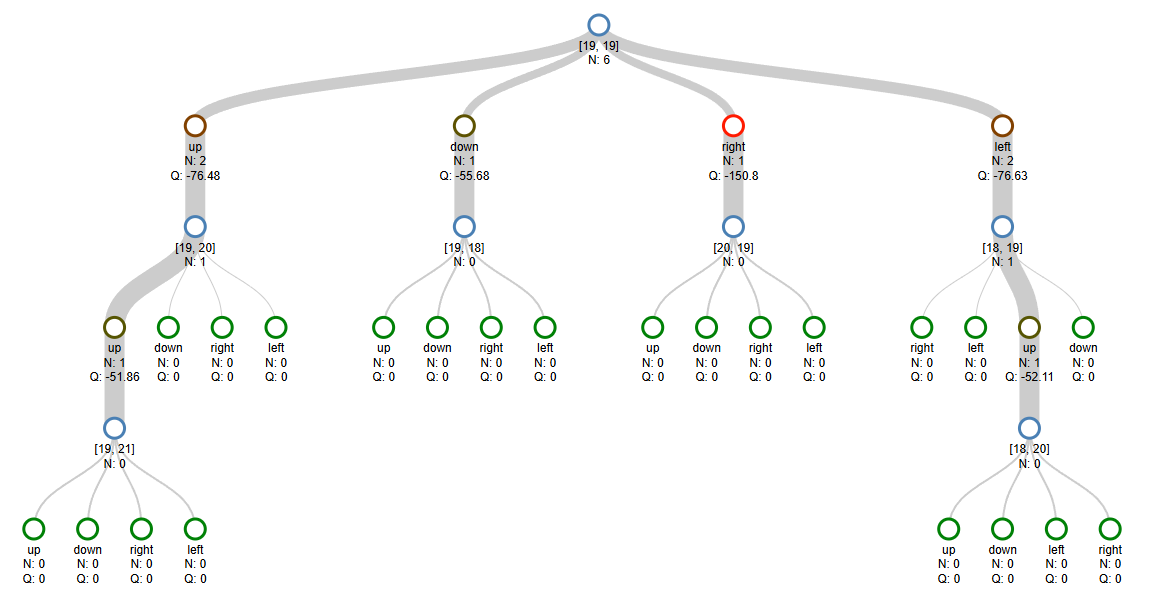


The tree shows that each of the actions from the start position was taken. We can see that generally the :up action generally has a high Q value because of the nearby reward state at [20,20]

----
## Question 4

In [57]:
# A starting point for the MCTS select_action function (a policy) which can be used for Questions 4 and 5

function select_action(m, s)

    start = time_ns()
    n = Dict{Tuple{statetype(m), actiontype(m)}, Int}()
    q = Dict{Tuple{statetype(m), actiontype(m)}, Float64}()
    t = Dict{Tuple{statetype(m), actiontype(m), statetype(m)}, Int}()


    for _ in 1:1000
    # while time_ns() < start + 40_000_000 # you can replace the above line with this if you want to limit this loop to run within 40ms
        simulate!(m, s, 150, 2(100-(-50)), n, q, t) # replace this with mcts iterations to fill n and q
    end

    # select a good action based on q and/or n

    return actions(m)[argmax([q[(s,a)] for a in actions(m)])] # this dummy function returns a random action, but you should return your selected action
end


select_action (generic function with 1 method)

In [58]:

m = DenseGridWorld(seed=4)

@btime select_action(m, SA[35,35]) # you can use this to see how much time your function takes to run. A good time is 10-20ms.
# @benchmark select_action(m, SA[35,35]) 

# use the code below to evaluate the MCTS policy
# @show results = [rollout(m, select_action, rand(initialstate(m)), 100) for _ in 1:100]
# @show mean(results)
# @show std(results) / sqrt(length(results))

  56.282 ms (445526 allocations: 21.79 MiB)


:up

---
## Problem 5: Challenge Problem

In [60]:
HW3.evaluate(select_action, "calvin.henggeler@colorado.edu")

Progress: 100%|█████████████████████████████████████████| Time: 0:03:04
┌ Warning: Your score is capped at 50/100. To get a higher score, enable the time option on evaluate with evaluate(...,time=true).
└ @ DMUStudent.HW3 none:69
┌ Info: Please submit results.json to gradescope.
└ @ DMUStudent.HW3 none:80


(assignment = "hw3", email = "calvin.henggeler@colorado.edu", score = 50.0, hash = "e1125ca39f1745aac97bfb91d0a5437cd9f2aaca7888f8c0471b4a53de9eee4c")

For the challenge problem, I used my Monte Carlo tree search algorithm code and adjusted some of the parameters for the return to be more optimal. The rollout policy that I used was the value estimate at the sate which I put into a function called U_value_function(m,s). I did not adjust this from previous usages in the homework. The main strategy that I took was to adjust my search depth and exploration constant. I found that as I increased depth, the time needed to compute the select_action, which calls simulate!(),  took longer, but resulted in a better score. Adjusting the exploration constant had less of a noticeable effect on execution time. I narrowed in the ‘d’ and ‘c’ parameters such that the simulation/ tree search wasn’t too deep as to take too long to compute, but was deep enough to select the optimal action. The sweet spot that allowed me to achieve a score of 50 was a depth of d=150 and exploration constant of c=75.